In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.special import rel_entr
import os
from python_src.compositions import replace_zero_aitchison
from scipy.spatial.distance import braycurtis

# Global Variables

In [77]:
# Change this depending on your data.
taxonomic_rank = 'Genus'
base_path = "pipelines/camisimGI/bio4"
rel_abund_file = "s1_genus_relabund.csv"
program_name = "Biobakery4"
sample_id = "s1"

expected_input = "pipelines/camisimGI/s1_expected.csv"

## Utils

In [78]:
# Use this once scipy fixes the bug.
# from skbio.stats.composition import clr
# from scipy.spatial.distance import euclidean

# def aitchinson_distance(x, y):
#     return euclidean(clr(x), clr(y))

# One Sample, One Expected

In [79]:
# Generate the expected result from the tsv file. Returns a dataframe.
def generate_expected(input_path: str, plot: bool = False) -> pd.DataFrame:
    expected = pd.read_csv(input_path, sep=',', index_col=0, names=['Organism', 'Counts'], header=0)
    expected = expected[['Counts']].astype(int)

    # Calculate expected relative abundance.
    expected['RA'] = expected['Counts'] / expected['Counts'].sum()

    # Let's split the organism index into two columns to find the genera.
    orgs = expected.index.to_list()
    genus = [org.strip().split(' ')[0] for org in orgs]
    genus = [x.replace('M.', 'Micromonospora') for x in genus]

    # Apparently, propionibacterium have been renamed to cutibacterium.
    genus = [x.replace('Propionibact.', 'Cutibacterium') for x in genus]

    # Add the columns to the dataframe.
    expected['Genus'] = genus
    # display(expected.head(12))

    # Group by genus and sum the counts for overlapping genera.
    exp_genus = expected.groupby('Genus').sum()
    exp_genus.sort_values('RA', ascending=False, inplace=True)

    if plot:
        exp_genus.plot.bar(y='RA', figsize=(8, 5), legend=False, title='Expected Relative Abundance')
    
    return exp_genus

# Use generate_expected to generate the expected result for the bmock12 data.
# exp_genus = generate_expected('pipelines/bmock12/s1_exp_raw.csv')
# exp_genus["RA"].to_csv('pipelines/bmock12/s1_expected.csv', index_label="Genus")

In [80]:
# For camisim, we can just read the csv in directly.
# exp_genus = pd.read_csv(expected_input, index_col=0, names=['Genus', 'RA'], header=0)
# exp_genus = exp_genus.where(exp_genus['RA'] > 0.001).dropna()

# (exp_genus.where(exp_genus['RA'] > 0.001).dropna()).to_csv('pipelines/camisimGI/s2_genus_pretty.csv', index_label="Genus")

In [81]:
def generate_experimental_df(input_path: str, index_name: str) -> pd.DataFrame:
    # Now, load in the experimental values.
    r_genus = pd.read_csv(input_path, index_col=0, names=[index_name, "RA"], header=0)
    # display(r_genus.head(12))
    r_genus = r_genus[['RA']].astype(float)

    return r_genus

# Instead, let's concat the two dataframes into long format and add a column from where it originated.
def long_format(df1, df2):
    merged = pd.concat([df1, df2], axis=0)

    # !!! This is slick
    merged['Source'] = ['Expected'] * len(df1) + ['Observed'] * len(df2)

    return merged

# result_genus = generate_experimental_df(os.path.join(base_path, rel_abund_file), taxonomic_rank)
# display(result_genus.head(12))
# merged_lf = long_format(exp_genus, result_genus)

# Plotting Tools

In [82]:
def linear_regression(df: pd.DataFrame, exp_df: pd.DataFrame, plot: bool = False, save_path: str = None) -> pd.DataFrame:
    # Merge on the genus key for easy plotting. The expected results are on the left, the observed on the right.
    # linear_df = exp_genus.merge(df, left_index=True, right_index=True)

    # try join because the left merge will drop the genera that are not in the observerd results, but we want to show that the experimental missed it.
    linear_df = exp_df.join(df, how='left', lsuffix='_x', rsuffix='_y')
    linear_df.fillna(0, inplace=True)

    # Linear regression with scikit.
    X = linear_df['RA_x'].values.reshape(-1, 1)
    Y = linear_df['RA_y'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    # Scatter plot of RA_x vs. RA_y.
    if plot:
        fig = plt.figure(figsize=(10, 8))
        plt.scatter(linear_df['RA_x'], linear_df['RA_y'], color='black')

        # Calculate mean absolute error.
        mae = np.mean(np.abs(linear_df['RA_x'] - linear_df['RA_y']))

        # Regression line.
        plt.plot(X, y_pred, color='red', linewidth=2)
        # Labels.
        plt.xlabel('Expected Relative Abundance')
        plt.ylabel('Observed Relative Abundance')
        plt.title(f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}')

        # Add r^2 value.
        plt.text(0.1, 0.9, f'r^2 = {reg.score(X,Y):.4f}', transform=plt.gca().transAxes)
        # Add MAE.
        plt.text(0.1, 0.85, f'MAE = {mae:.4f}', transform=plt.gca().transAxes)

        # Add line y = x.
        plt.plot([0, 1], [0, 1], color='blue', linewidth=2, linestyle='--')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    return linear_df
    
# linear_regression(result_genus, exp_genus, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bivariate_{taxonomic_rank}.png"))

In [83]:
# Bar plot of RA_x vs. RA_y side by side.
# sns.set_style("whitegrid")
def bar_plot(df: pd.DataFrame, plot: bool = False, save_path: str = None, program=program_name, title=f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}', hue_category='Source'):
    subset = pd.DataFrame()

    for x, y in df.groupby(taxonomic_rank):
        if y["Source"].values[0] == "Expected":
            subset = pd.concat([y, subset], axis=0)

    subset = subset.where(subset['RA'] > 0.001).dropna()

    if plot:
        # display(subset.head(12))
        # display(df.head(12))
        # Plot a category bar chart with the colors based on the source.
        fig = plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=subset.index, y='RA', hue=hue_category, data=subset, errorbar=None)
        ax.semilogy()
        # ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
        # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_title(title)
        ax.set_xlabel('Genus')
        ax.set_ylabel('Relative Abundance')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# bar_plot(merged_lf, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bars_{taxonomic_rank}.png"))

# Multisample
## Utilities

In [84]:
# We will now aggregate the differences by pipeline. 
# To do this, we will start at the root and walk down, looking for "relabund" files and "expected" files.

# root_dir = "pipelines/camisimGI/"

def get_all_expected(root_dir: str, rank="genus"):
    combined_expected = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if f"expected_{rank}" in f and f.endswith(".csv"):
                # print(f)
                df = pd.read_csv(os.path.join(root, f), index_col=0, names=['Genus', 'RA'], header=0)
                df["Source"] = "Expected"

                # Files are of s#_expected.csv, so we can split on the underscore and take the first part.
                df["SampleID"] = f.split("_")[0]
                combined_expected = pd.concat([combined_expected, df], axis=0)

    return combined_expected

In [85]:
def get_relabund_files(root_dir: str, rank="genus"):
    combined_df = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if "relabund" in f and rank in f and f.endswith(".csv"):
                # print(root, f)
                p = os.path.join(root, f)
                exp = generate_experimental_df(p, taxonomic_rank)

                # Add a column to the experimental dataframe with the pipeline name.
                exp['Source'] = os.path.dirname(p).split('/')[-1]

                # Add sampleID to the experimental dataframe.
                exp['SampleID'] = os.path.basename(p).split('_')[0]

                # Add the experimental dataframe to the combined dataframe.
                combined_df = pd.concat([combined_df, exp], axis=0)

    # Ensure that the RA column is a float.
    combined_df['RA'] = combined_df['RA'].astype(float)

    return combined_df

In [86]:
def fully_combined(root_dir):
    combined_df = get_relabund_files(root_dir)
    combined_expected = get_all_expected(root_dir)

    # Merge the expected and experimental dataframes.
    merged = pd.concat([combined_expected, combined_df], axis=0)
    merged = merged.reset_index()
    merged = merged.rename(columns={'index': 'Genus'})
    merged = merged.set_index('Genus')

    # display(merged.head())

    return merged

## Multisample with Different Expected Values

In [87]:
def plot_by_sample(root, output_dir, hue_category='Source'): 
    full_df = fully_combined(root)
    for sample_id, df in full_df.groupby('SampleID'):
        title = f"Expected vs. Observed Relative Abundance for {sample_id} ({taxonomic_rank})"
        # display(df.head())
        if output_dir is not None:
            bar_plot(df, plot=True, save_path=os.path.join(output_dir, f"{sample_id}_bars_{taxonomic_rank}_all.png"), title=title)
        else:
            bar_plot(df, plot=True, save_path=None, title=title)

# plot_by_sample(root_dir, hue_category='SampleID')

In [88]:
def linear_regression(X, Y):
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    return reg, y_pred

def linear_plot(input_df: pd.DataFrame, title, sample_id, hue_category="Source_observed", save_path=None, inset=False) -> pd.DataFrame:
    """
    Plot a linear regression of the expected vs. observed relative abundance. Also calculates the R^2 value, MAE, and Aitchison distance.
    Parameters:
        input_df: A dataframe with the expected and observed relative abundance. The third column should be the source of the data.
        title: The title of the plot.
        sample_id: The sample ID of the plot.
        hue_category: The category to use for the hue (default: "Source_observed").
        save_path: The path to save the plot to (if None, the plot will not be saved).
        inset: Whether or not to plot the inset.
    Returns:
        A dataframe with the R^2, MAE, and Aitchison distance with pipeline and sampleID.
    """
    stats_df = pd.DataFrame()

    fig = plt.figure(figsize=(20, 20))
    ax = sns.lmplot(x="RA_expected", y="RA_observed", hue=hue_category, data=input_df, fit_reg=True, height=7, aspect=11/7, ci=None)

    # Make linear regression for each pipeline (or sampleID for replicates).
    pipeline_offset = 0.90
    for heading, dataframe in input_df.groupby(hue_category):
        x = dataframe["RA_expected"].values.reshape(-1, 1)
        y = dataframe["RA_observed"].values.reshape(-1, 1)
        reg, y_pred = linear_regression(x, y)

        # Calculate R^2.
        r2 = reg.score(x, y)

        # Add r^2
        plt.text(0.1, pipeline_offset, f'r\u00b2 = {r2:.4f} for {heading}', transform=plt.gca().transAxes)

        # Calculate MAE.
        mae = np.mean(np.abs(dataframe['RA_expected'] - dataframe['RA_observed']))

        # Add MAE
        plt.text(0.4, pipeline_offset, f'MAE = {mae:.4f} for {heading}', transform=plt.gca().transAxes)

        # Add the aitchison distance.
        try: 
            a_d = replace_zero_aitchison(dataframe['RA_expected'].values, dataframe['RA_observed'].values)
            plt.text(0.7, pipeline_offset, f'Aitchison = {a_d:.4f} for {heading}', transform=plt.gca().transAxes)

            # Make a dataframe with sampleID as the index and the R^2, MAE, and Aitchison distance as the columns.
            stats = {'R^2': r2, 'MAE': mae, 'Aitchison': a_d}
            stats_df = pd.concat([stats_df, pd.DataFrame(stats, index=[heading])])


        except ValueError as e:
            print(f"ValueError: {e}")
            # If there is a zero in the data, we cannot calculate the aitchison distance.
            plt.text(0.7, pipeline_offset, f'Aitchison = N/A for {heading}', transform=plt.gca().transAxes)

            # s = pd.Series({'SampleID': sample_id, 'Pipeline': heading, 'R^2': r2, 'MAE': mae, 'Aitchison': np.nan}) 
            # stats_df = pd.concat([stats_df, s], ignore_index=True)

        """
        # Add the bray-curtis distance.
        try: 
            a_d = 1 - braycurtis(dataframe['RA_expected'].values, dataframe['RA_observed'].values)
            plt.text(0.7, pipeline_offset, f'1-BC = {a_d:.4f} for {heading}', transform=plt.gca().transAxes)
        except ValueError:
            plt.text(0.7, pipeline_offset, f'1-BC = N/A for {heading}', transform=plt.gca().transAxes)
        """

        # Calculate relative entropy using scipy.special.rel_entr
        # Not sure if this works since sometimes the observed is smaller than the expected.
        # re = rel_entr(dataframe['RA_expected'], dataframe['RA_observed']).sum()
        # print(re)
        # Add relative entropy
        # plt.text(0.7, pipeline_offset, f'Relative Entropy = {re:.4f} for {heading}', transform=plt.gca().transAxes)

        # Move the offset down. 
        pipeline_offset -= 0.05

    # Add title.
    plt.title(title)

    # Add y = x line.
    ## Get the max x and max y values.
    max_x = input_df['RA_expected'].max()
    max_y = input_df['RA_observed'].max()
    max_val = max(max_x, max_y)

    # Plot a line from (0, 0) to (max_x+0.1, max_y+0.1)
    plt.plot([0, max_val + 0.01], [0, max_val + 0.01], ls="--", c=".3")

    # Add an inset for the x values between 0 and 0.05.
    if inset:
        left, bottom, width, height = [0.65, 0.15, 0.25, 0.25]
        ax2 = ax.fig.add_axes([left, bottom, width, height])
        ax2 = sns.scatterplot(x="RA_expected", y="RA_observed", hue=hue_category, data=input_df, ax=ax2, legend=False)
        ax2.set_xlim(-0.001, 0.02)
        ax2.set_ylim(-0.001, 0.02)
        ax2.set_title("Zoomed In")

    if save_path is not None:
        ax.figure.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    return stats_df

In [89]:
def linear_plot_log(input_df: pd.DataFrame, title, sample_id, hue_category="Source_observed", save_path=None):
    # We want to plot the x and y axis on a log scale.
    fig = plt.figure(figsize=(20, 20))
    ax = sns.lmplot(x="RA_expected", y="RA_observed", hue=hue_category, data=input_df, fit_reg=True, height=7, aspect=11/7, ci=None, truncate=True)
    # ax.set(xscale="symlog", yscale="symlog")

In [90]:
# Convert from Genus, RA, Source, SampleID to Genus RA_x, RA_y, Source, SampleID.
def convert_to_bivariate(root_dir: str, save_path=None, log=False):
    df = fully_combined(root_dir)
    for sample, sample_df in df.groupby('SampleID'):
        bivariate_df = pd.DataFrame()
        # Get the expected dataframe.
        expected = sample_df[sample_df['Source'] == 'Expected']
        # display(expected)

        # Get the dirname of the root directory.
        dirname = root_dir.split('/')[-1]
        # print(dirname)

        # Get the experimental dataframe.
        experimental = sample_df[(sample_df['Source'] != 'Expected') & (sample_df['Source'] != dirname)]
        # display(experimental)

        # Merge the expected and experimental dataframes.
        merged = pd.merge(expected, experimental, on='Genus', how='left', suffixes=('_expected', '_observed'))
        merged['SampleID'] = sample
        # merged["RA_observed"] = merged["RA_observed"].fillna(0)

        # Add the merged dataframe to the bivariate dataframe.
        bivariate_df = pd.concat([bivariate_df, merged], axis=0)

        # bivariate_df = bivariate_df.sort_values(by='RA_expected', ascending=False).head(30)
        plotting_function = None
        if log:
            plotting_function = linear_plot_log
        else:
            plotting_function = linear_plot

        if save_path is not None:
            plotting_function(bivariate_df, "Bivariate Linear Regression for Sample " + sample, sample, hue_category="Source_observed", save_path=os.path.join(root_dir, f"{sample}_linear_{taxonomic_rank}_all.png"))
        else:
            plotting_function(bivariate_df, "Bivariate Linear Regression for Sample " + sample, sample, hue_category="Source_observed", save_path=None)

    return bivariate_df

# bivariate_df = convert_to_bivariate(fully_combined())

## Multiple Samples (Replicates) with One Expected

In [91]:
# This function is used for multiple samples from the same pipeline against the same expected.
def plot_many_versus_expected(root_dir, output_dir, in_df, rank):
    exp = get_all_expected(root_dir, rank)
    dirname = root_dir.split('/')[-1]
    for pipeline, df in in_df.groupby('Source'):
        print(pipeline)
        if pipeline == 'Expected':
            continue
        
        if pipeline != dirname:
            fig = plt.figure(figsize=(15, 12))

            df = df.where(df['RA'] > 0.001).dropna()

            # Add the expected dataframe to the combined dataframe.
            merged = pd.concat([exp, df], axis=0)

            ax = sns.barplot(x=merged.index, y='RA', hue="SampleID", data=merged, errorbar=None, log=True)
            ticks = [0.001, 0.01, 0.10]
            ax.set_yticks(ticks)
            ax.set_yticklabels(ticks)
            # ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
            # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

            title = f"Expected vs. Observed Relative Abundance for {rank} using {pipeline}"
            ax.set_title(title)
            ax.set_xlabel('Genus')
            ax.set_ylabel('Relative Abundance')

            plt.savefig(os.path.join(output_dir, f"{pipeline}", f"{pipeline}_bars.png"), dpi=300, bbox_inches='tight')
        else:
            continue

# plot_many_versus_expected(root_dir, fully_combined(), "genus")

In [92]:
# This function will plot the expected vs. observed for each sample in each pipeline.
# There is only one expected value for each sample since they are replicates.
# This will be a bivariate plot.
def plot_many_versus_expected_bivariate(root_dir, observed_df, expected_df, rank, inset) -> pd.DataFrame:
    """
    This function will plot the expected vs. observed for each sample in each pipeline. 
    There is only one expected value for each sample since they are replicates. 
    This will be a bivariate plot that will include MAE, r^2 and Aitchison distance.

    Parameters
    ----------
    root_dir : str
        The root directory of the pipeline.
    observed_df : pd.DataFrame
        The observed dataframe.
    expected_df : pd.DataFrame
        The expected dataframe.
    rank : str
        The taxonomic rank.
    inset : bool
        Whether or not to include an inset plot.

    Returns
    -------
    pd.DataFrame
        A dataframe containing the statistics for each sample.
    """
    # First, we need to make a df of observed vs. expected for each sample.
    combined_stats = pd.DataFrame()
    for pipeline, pipeline_df in observed_df.groupby("Source"):
        # Plotting expected vs expected is useless.
        if pipeline == "tourlousse" or pipeline == "Expected":
            continue

        merged = pd.merge(expected_df.copy(), pipeline_df, on='Genus', how='left', suffixes=('_expected', '_observed'))

        save_path = os.path.join(root_dir, pipeline, f"{pipeline}_bivariate_{rank}_all_samples.png")
        # merged.to_csv(os.path.join(root_dir, pipeline, f"{pipeline}_bivariate_{rank}_all_samples.csv"))

        pipeline_stats = linear_plot(merged, f"Expected vs. Observed Relative Abundance for {rank} using {pipeline}", pipeline, hue_category="SampleID_observed", save_path=save_path, inset=inset)

        # Add pipeline column to the stats dataframe equal to the pipeline name.
        pipeline_stats['Pipeline'] = pipeline

        # Add the pipeline stats to the combined stats dataframe.
        combined_stats = pd.concat([combined_stats, pipeline_stats], axis=0)

    return combined_stats

# plot_many_versus_expected_bivariate(get_relabund_files(root_dir), get_all_expected(root_dir, "genus"), "genus")

# Run the code here: MAIN.

<Figure size 2000x2000 with 0 Axes>

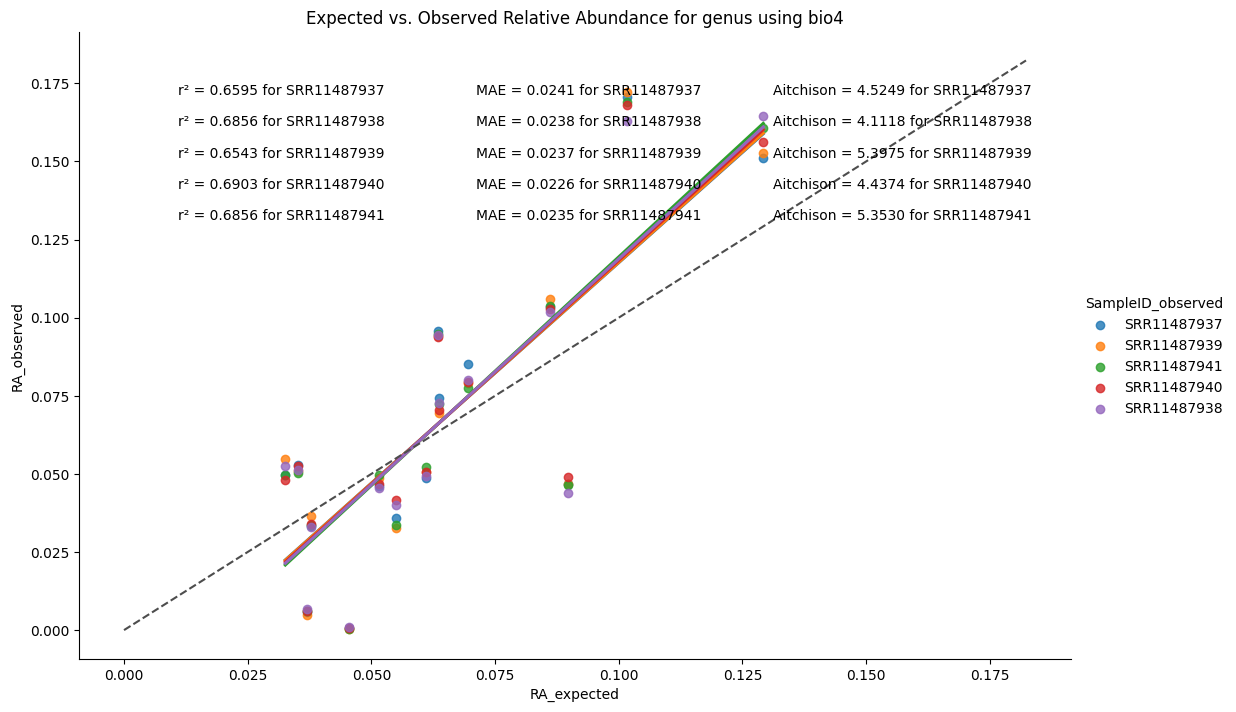

<Figure size 2000x2000 with 0 Axes>

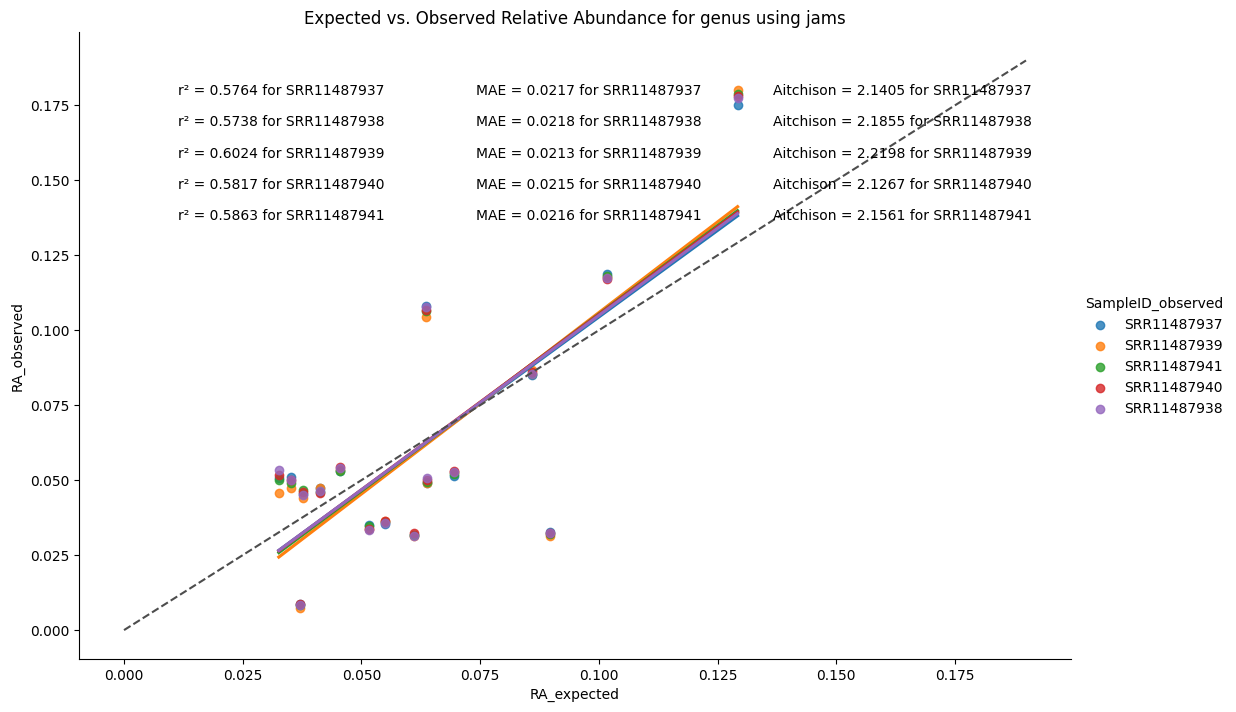

<Figure size 2000x2000 with 0 Axes>

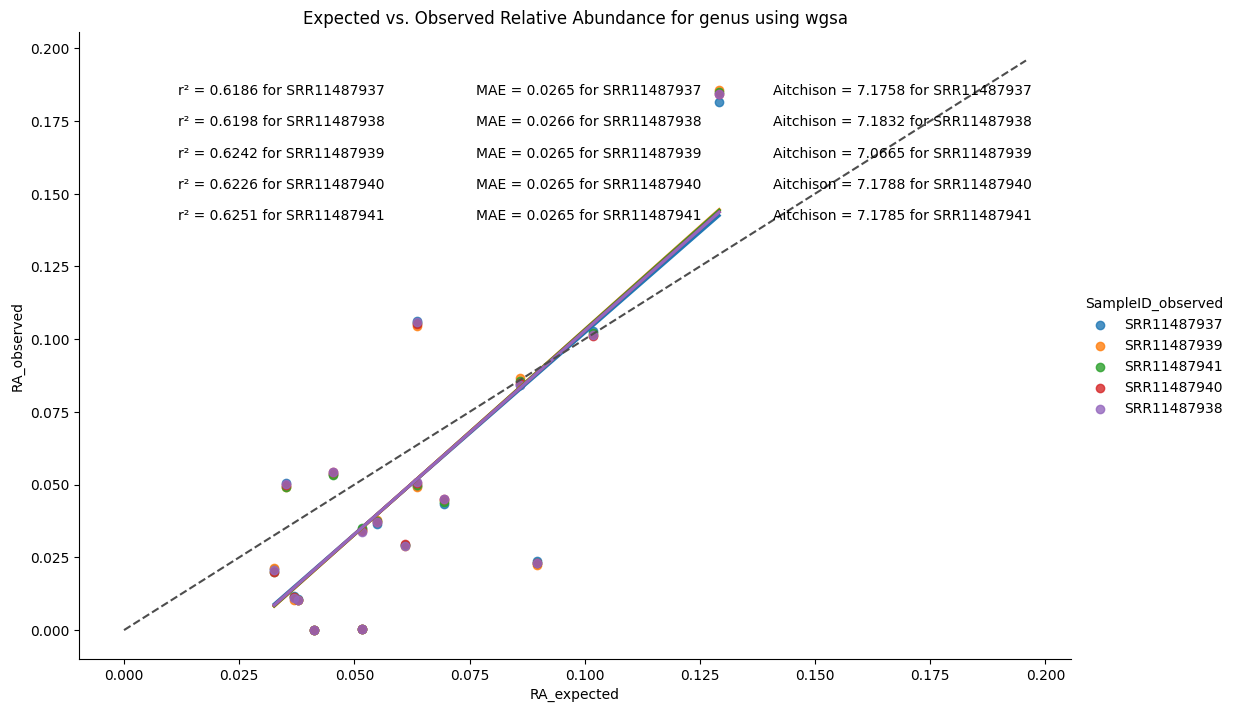

<Figure size 2000x2000 with 0 Axes>

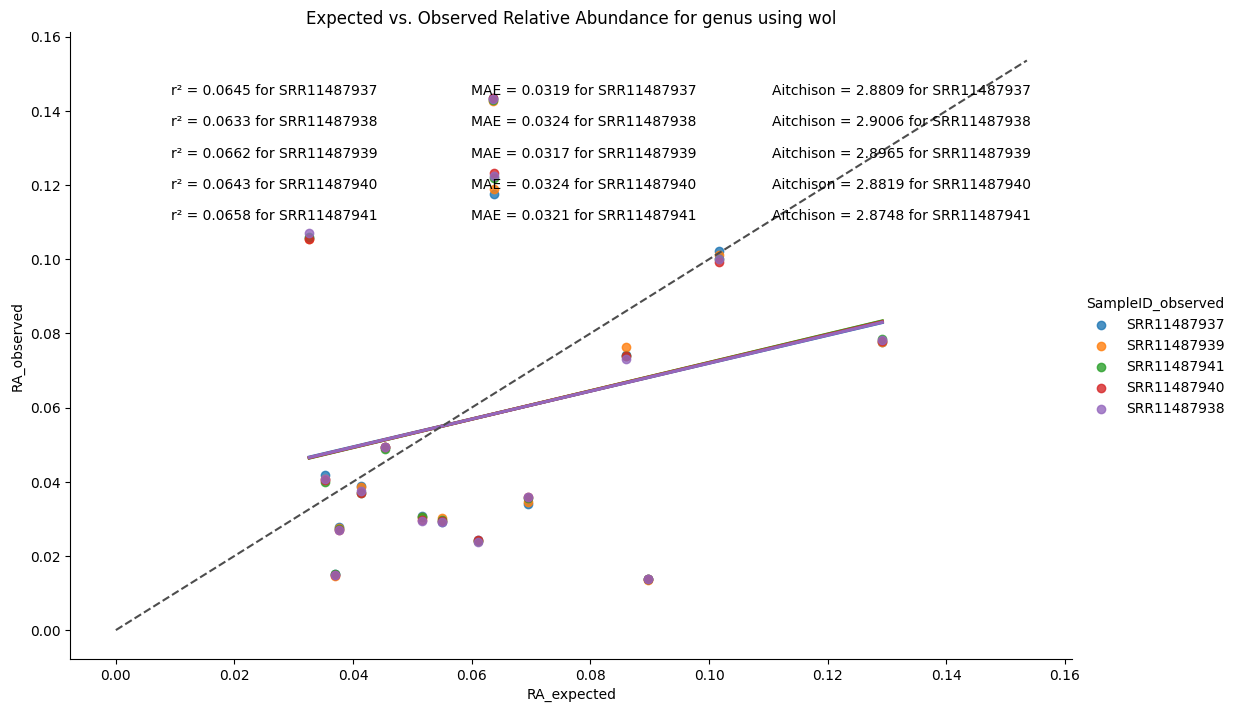

In [93]:
def main():
    # No ending slash for this directory.
    root_dir = "pipelines/amos/mixed"

    # plot_by_sample(root=root_dir, output_dir=root_dir, hue_category="Source")
    # convert_to_bivariate(root_dir, save_path=root_dir, log=False)

    # plot_many_versus_expected(root_dir, root_dir, fully_combined(root_dir), "genus")
    final_stats = plot_many_versus_expected_bivariate(root_dir, fully_combined(root_dir), get_all_expected(root_dir, "genus"), "genus", inset=False)
    final_stats.to_csv(os.path.join(root_dir, "all_stats_replicates.csv"), index_label="SampleID")

main()